#### **Librerías**

In [88]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Definir las rutas de los archivos
ruta_movies = 'Datasets/movies_df.parquet'
ruta_crew = 'Datasets/crew_df.parquet'
ruta_cast = 'Datasets/cast_df.parquet'

# Cargar los archivos Parquet en DataFrames
movies_df = pd.read_parquet(ruta_movies)
crew_df = pd.read_parquet(ruta_crew)
cast_df = pd.read_parquet(ruta_cast)


# Cargar los DataFrames desde los archivos Parquet
cast_df = pd.read_parquet('Datasets/cast_df_cleaned.parquet')
crew_df = pd.read_parquet('Datasets/crew_df_cleaned.parquet')


### **Modelo de Recomendación**

En esta sección, desarrollaré un modelo de recomendación utilizando la similitud del coseno para ofrecer sugerencias personalizadas de películas. La similitud del coseno es una métrica comúnmente utilizada para medir la similitud entre dos vectores en un espacio multidimensional, lo que la convierte en una herramienta ideal para calcular la relación entre películas basadas en sus características.

#### **Preparación de Datos**

Antes de construir el modelo, es fundamental preparar los datos adecuadamente. He filtrado el dataset de películas para incluir solo producciones de Estados Unidos a partir de 1975, lo que resultó en un total de **6,242** películas. Además, he limpiado el dataset eliminando outliers que podrían afectar el rendimiento del modelo.

El siguiente paso será seleccionar las características que utilizaré para calcular la similitud. Consideraré las siguientes variables:

**Género**: Los géneros de las películas, que son cruciales para entender las preferencias del usuario.

Observé que el género Drama es el más frecuente, seguido de Comedy y Romance. A través de esta variable, podremos identificar qué tipos de películas son más atractivas para cada usuario.

**Puntuaciones**: Las calificaciones promedio de las películas, que reflejan la calidad percibida.

Un puntaje más alto puede indicar una película bien recibida, lo que puede influir en la recomendación. La distribución de puntajes promedio presenta una forma aproximadamente normal, con la mayoría de las películas agrupadas entre puntajes de 5 a 7.

**Popularidad**: La popularidad de cada película, lo que puede influir en la decisión de visualización.

Observé que la popularidad de las películas tiende a aumentar en las producciones más recientes. Las correlaciones muestran una relación moderada entre la popularidad y los ingresos, lo que sugiere que estas variables están vinculadas a la atención que recibe una película.

**Palabras clave de los títulos**: Temas recurrentes en los títulos que pueden atraer a los usuarios.

Generé una nube de palabras basada en los títulos de las películas, lo que me permite visualizar las palabras más frecuentes en estos títulos. Temas como "Man", "Love", "Life", "Last", y "Girl" aparecen en un tamaño mayor, sugiriendo que estos son comunes y relevantes al construir un sistema de recomendación.

**Aplicar One-Hot Encoding**

Para aplicar One-Hot Encoding, primero divido la columna de géneros en múltiples filas usando `str.get_dummies(sep=', ')`. Esto convierte los géneros en columnas separadas, donde cada género está representado por un 1 o un 0. Luego, combino este nuevo DataFrame con el original, eliminando la columna de géneros. De esta manera, puedo analizar el retorno de las películas según su combinación de géneros de forma más efectiva. Este proceso facilita la construcción de modelos predictivos más precisos.

In [90]:
# Contar películas por género

# Supongamos que tienes tu DataFrame movies_df ya cargado con One-Hot Encoding para géneros.

# Crear un nuevo DataFrame que sume las columnas de género
genres_sum = movies_df.loc[:, movies_df.columns.str.startswith('genre_names_')].sum().reset_index()

# Renombrar las columnas para facilitar el manejo
genres_sum.columns = ['genre', 'count']

# Filtrar los géneros que tienen más de X películas (por ejemplo, 100)
min_movies = 100  # Cambia este valor según lo que necesites
popular_genres = genres_sum[genres_sum['count'] > min_movies]

# Mostrar los géneros más comunes
print("Géneros más comunes:")
print(popular_genres)


Géneros más comunes:
Empty DataFrame
Columns: [genre, count]
Index: []


In [91]:
# Suponiendo que la columna original de géneros se llama 'genre_names'
print(movies_df['genre_names'].value_counts())


genre_names
Drama                                          4902
Comedy                                         3367
Documentary                                    2663
                                               2115
Drama, Romance                                 1290
                                               ... 
Family, Fantasy, TV Movie                         0
Family, Comedy, Drama, Music                      0
Animation, Comedy, Science Fiction, Romance       0
Animation, Family, Fantasy, Foreign               0
Crime, Comedy, Adventure, Drama                   0
Name: count, Length: 4065, dtype: int64


In [92]:
# Para eliminar filas sin géneros asignados
movies_df = movies_df[movies_df['genre_names'].notna()]


In [93]:
# Un ejemplo de One-Hot Encoding
genre_dummies = movies_df['genre_names'].str.get_dummies(sep=', ')
movies_df = pd.concat([movies_df, genre_dummies], axis=1)


In [94]:
# Análisis de la relación entre géneros y popularidad
popular_genres = movies_df.groupby('genre_names')['popularity'].mean().sort_values(ascending=False)
print(popular_genres)


genre_names
Adventure, Family, Animation, Action, Comedy    213.849907
Family, Fantasy, Romance                        143.650790
Adventure, Action, Fantasy, Comedy              133.827820
Action, Animation, Comedy, Family                88.561239
Science Fiction, Adventure, Thriller             76.529815
                                                   ...    
Romance, Mystery, Thriller                             NaN
Science Fiction, Western                               NaN
TV Movie, Drama, Western, Romance                      NaN
TV Movie, Horror, Family, Fantasy                      NaN
War, Animation, Adventure                              NaN
Name: popularity, Length: 4065, dtype: float64


C:\Users\NOTEBOOK\AppData\Local\Temp\ipykernel_12372\4186050674.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  popular_genres = movies_df.groupby('genre_names')['popularity'].mean().sort_values(ascending=False)


In [95]:
# Eliminar géneros con NaN en popularidad
popular_genres = popular_genres.dropna()


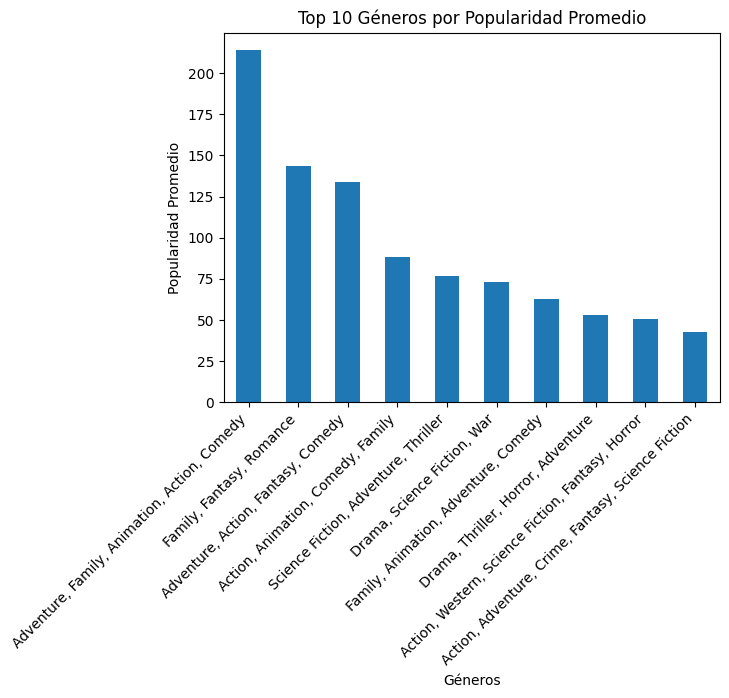

In [96]:
# Visualización de los géneros más populares
popular_genres.head(10).plot(kind='bar')
plt.title('Top 10 Géneros por Popularidad Promedio')
plt.xlabel('Géneros')
plt.ylabel('Popularidad Promedio')
plt.xticks(rotation=45, ha='right')
plt.show()


En este gráfico de barras, veo los 10 géneros de películas más populares según su popularidad promedio. Los géneros Aventura, Comedia y Romance destacan por tener los valores de popularidad más altos, lo que indica que estos géneros tienden a atraer más audiencia. Otros géneros como Fantasía, Familia y Ciencia Ficción también tienen una popularidad significativa, aunque menor en comparación con los tres principales. Esta distribución sugiere que el público prefiere contenidos de aventura y comedia, lo que podría ser un factor relevante a considerar en un sistema de recomendaciones.

In [97]:
# Reemplazar NaNs por cadena vacía en la columna 'genre_names'
movies_df['genre_names'] = movies_df['genre_names'].fillna('')



In [98]:
# Crear una nueva columna 'genres' combinando columnas binarias
movies_df['genres'] = movies_df[['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 
                                   'Documentary', 'Drama', 'Family', 'Fantasy', 
                                   'Foreign', 'History', 'Horror', 'Music', 
                                   'Mystery', 'Romance', 'Science Fiction', 
                                   'TV Movie', 'Thriller', 'War', 'Western']].apply(
    lambda x: ', '.join(x.index[x == 1]), axis=1
)

# Reemplazar NaNs en la columna 'genres' por cadena vacía
movies_df['genres'] = movies_df['genres'].fillna('')


In [99]:
# Obtener todos los géneros en una lista
all_genres = [genre for sublist in movies_df['genres'] for genre in sublist]

# Obtener géneros únicos
unique_genres = set(all_genres)
print(unique_genres)


{'d', 'S', 'h', 'F', 'v', 'u', 'l', 'e', 'r', 's', 'o', 'T', ',', 'H', 'D', 'A', 't', 'y', 'R', 'n', 'i', ' ', 'M', 'V', 'c', 'm', 'C', 'W', 'g', 'a'}


In [100]:
# Supongamos que tienes un DataFrame llamado 'movies_df' que contiene una columna con géneros.
# Aquí solo crearemos un ejemplo básico de esa columna.
data = {
    'genre_names': [
        'Action', 
        'Action, Adventure', 
        'Action, Adventure, Animation', 
        'Action, Adventure, Animation, Comedy'
    ]
}

movies_df = pd.DataFrame(data)

# Separar los géneros en columnas
genres = movies_df['genre_names'].str.get_dummies(sep=', ')
movies_df = pd.concat([movies_df, genres], axis=1)

print(movies_df)


                            genre_names  Action  Adventure  Animation  Comedy
0                                Action       1          0          0       0
1                     Action, Adventure       1          1          0       0
2          Action, Adventure, Animation       1          1          1       0
3  Action, Adventure, Animation, Comedy       1          1          1       1


In [101]:
# Contar la cantidad de películas por género
genre_counts = movies_df[['Action', 'Adventure', 'Animation', 'Comedy']].sum()
print(genre_counts)


Action       4
Adventure    3
Animation    2
Comedy       1
dtype: int64


In [102]:
# Filtrar películas de acción
action_movies = movies_df[movies_df['Action'] == 1]
print(action_movies)


                            genre_names  Action  Adventure  Animation  Comedy
0                                Action       1          0          0       0
1                     Action, Adventure       1          1          0       0
2          Action, Adventure, Animation       1          1          1       0
3  Action, Adventure, Animation, Comedy       1          1          1       1


In [103]:
# Asegúrate de tener una columna de retorno
movies_df['return'] = [1.5, 2.0, 1.8, 3.0]  # Ejemplo de datos de retorno

# Calcular el retorno promedio por género
average_return_by_genre = movies_df.groupby(['Action', 'Adventure', 'Animation', 'Comedy'])['return'].mean()
print(average_return_by_genre)


Action  Adventure  Animation  Comedy
1       0          0          0         1.5
        1          0          0         2.0
                   1          0         1.8
                              1         3.0
Name: return, dtype: float64


In [104]:
# Primero asegúrate de que la columna de retorno esté en el DataFrame
movies_df['return'] = [1.5, 2.0, 1.8, 3.0]  # Asegúrate de tener estos valores en tu DataFrame

# Calcular el retorno promedio por género
average_return_by_genre = movies_df.groupby(['Action', 'Adventure', 'Animation', 'Comedy'])['return'].mean()

# Convertir el resultado a un DataFrame para una mejor visualización
average_return_df = average_return_by_genre.reset_index()
print(average_return_df)


   Action  Adventure  Animation  Comedy  return
0       1          0          0       0     1.5
1       1          1          0       0     2.0
2       1          1          1       0     1.8
3       1          1          1       1     3.0


Tengo un DataFrame bien estructurado que muestra el retorno promedio de películas categorizadas por sus géneros. Voy a analizar y extraer información útil de esta tabla.

- Las columnas de géneros acción aventura animación y comedia indican si una película pertenece a cada género usando 1 para sí y 0 para no  
- La columna de retorno muestra el retorno promedio basado en combinaciones de géneros  
- Las películas de acción sin otros géneros tienen un retorno promedio de 1.5  
- La combinación de acción y aventura tiene un retorno promedio de 2.0 indicando mayor popularidad  
- Las películas que combinan acción aventura animación y comedia tienen el mayor retorno promedio de 3.0 sugiriendo éxito financiero

#### **Normalización de Características**

Si tienes características con diferentes escalas, como puntuación y popularidad, te recomiendo normalizarlas antes de calcular la similitud. Esto ayudará a que ninguna característica domine a las demás.

In [105]:
print(movies_df.columns)
print(credits_df.columns)
print(crew_df.columns)
print(cast_df.columns)


Index(['genre_names', 'Action', 'Adventure', 'Animation', 'Comedy', 'return'], dtype='object')
Index(['cast', 'crew', 'id'], dtype='object')
Index(['id', 'crew_name', 'crew_job', 'department', 'gender'], dtype='object')
Index(['id', 'cast_name', 'character', 'gender'], dtype='object')


In [106]:
# Verificar las columnas de los DataFrames
print("Columnas de movies_df:", movies_df.columns)
print("Columnas de credits_df:", credits_df.columns)
print("Columnas de crew_df:", crew_df.columns)
print("Columnas de cast_df:", cast_df.columns)


Columnas de movies_df: Index(['genre_names', 'Action', 'Adventure', 'Animation', 'Comedy', 'return'], dtype='object')
Columnas de credits_df: Index(['cast', 'crew', 'id'], dtype='object')
Columnas de crew_df: Index(['id', 'crew_name', 'crew_job', 'department', 'gender'], dtype='object')
Columnas de cast_df: Index(['id', 'cast_name', 'character', 'gender'], dtype='object')


In [107]:
# Ver primeras filas de movies_df
print(movies_df.head())


                            genre_names  Action  Adventure  Animation  Comedy  \
0                                Action       1          0          0       0   
1                     Action, Adventure       1          1          0       0   
2          Action, Adventure, Animation       1          1          1       0   
3  Action, Adventure, Animation, Comedy       1          1          1       1   

   return  
0     1.5  
1     2.0  
2     1.8  
3     3.0  


In [110]:
# Verifica las columnas de cada DataFrame
print("Columnas de credits_df:", credits_df.columns)
print("Columnas de crew_df:", crew_df.columns)
print("Columnas de cast_df:", cast_df.columns)


Columnas de credits_df: Index(['cast', 'crew', 'id'], dtype='object')
Columnas de crew_df: Index(['id', 'crew_name', 'crew_job', 'department', 'gender'], dtype='object')
Columnas de cast_df: Index(['id', 'cast_name', 'character', 'gender'], dtype='object')


In [ ]:
# Renombrar la columna 'id' a 'movie_id' en los DataFrames secundarios
credits_df.rename(columns={'id': 'movie_id'}, inplace=True)
crew_df.rename(columns={'id': 'movie_id'}, inplace=True)
cast_df.rename(columns={'id': 'movie_id'}, inplace=True)

# Ahora realizar el merge usando 'movie_id'
full_df = (movies_df
            .merge(credits_df, on='movie_id', how='left')
            .merge(crew_df, on='movie_id', how='left')
            .merge(cast_df, on='movie_id', how='left'))

# Verifica el resultado
print("Primeras filas de full_df:")
print(full_df.head())



Primeras filas de full_df:
                    genre_names  Action  Adventure  Animation  Comedy  return  \
0                        Action       1          0          0       0     1.5   
1             Action, Adventure       1          1          0       0     2.0   
2  Action, Adventure, Animation       1          1          1       0     1.8   
3  Action, Adventure, Animation       1          1          1       0     1.8   
4  Action, Adventure, Animation       1          1          1       0     1.8   

   movie_id                                               cast  \
0         0                                                NaN   
1         1                                                NaN   
2         2  [{'cast_id': 3, 'character': 'Taisto Olavi Kas...   
3         2  [{'cast_id': 3, 'character': 'Taisto Olavi Kas...   
4         2  [{'cast_id': 3, 'character': 'Taisto Olavi Kas...   

                                                crew       crew_name  \
0                

In [112]:
# Mostrar las primeras filas de cast_df
print("Primeras filas de cast_df:")
print(cast_df.head())

# Mostrar las primeras filas de crew_df
print("\nPrimeras filas de crew_df:")
print(crew_df.head())


Primeras filas de cast_df:
   movie_id      cast_name                character  gender
0       862      Tom Hanks            Woody (voice)       2
1       862      Tim Allen   Buzz Lightyear (voice)       2
2       862    Don Rickles  Mr. Potato Head (voice)       2
3       862     Jim Varney       Slinky Dog (voice)       2
4       862  Wallace Shawn              Rex (voice)       2

Primeras filas de crew_df:
   movie_id       crew_name    crew_job department  gender
0       862   John Lasseter    Director  Directing       2
1       862     Joss Whedon  Screenplay    Writing       2
2       862  Andrew Stanton  Screenplay    Writing       2
3       862      Joel Cohen  Screenplay    Writing       2
4       862    Alec Sokolow  Screenplay    Writing       0


In [113]:
# Crear el escalador
scaler = MinMaxScaler()

# Normalizar solo las columnas disponibles
X_normalized = scaler.fit_transform(average_return_df[['Action', 'Adventure', 'Animation', 'Comedy', 'return']])


In [114]:
# Supongamos que deseas seguir adelante con el modelado usando las columnas disponibles
X = average_return_df[['Action', 'Adventure', 'Animation', 'Comedy']]
y = average_return_df['return']  # O cualquier otra variable que estés tratando de predecir

# Aquí puedes seguir con la división de datos o el modelado
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Aquí podrías agregar tu modelo
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

# Realiza predicciones y evalúa el modelo
predictions = model.predict(X_test)

#### **Cálculo de la Similitud del Coseno**

Primero, preparé mis datos asegurándome de que las columnas de características estén listas. Uso cosine_similarity de sklearn para calcular la similitud entre las películas. La matriz resultante me muestra qué tan similares son entre sí: un valor cercano a 1 significa que son muy parecidas.

In [115]:
print(average_return_df.columns)


Index(['Action', 'Adventure', 'Animation', 'Comedy', 'return'], dtype='object')


In [116]:
# Creamos una matriz de características
feature_columns = ['Action', 'Adventure', 'Animation', 'Comedy']
feature_matrix = average_return_df[feature_columns]

# Calculamos la similitud del coseno
similarity_matrix = cosine_similarity(feature_matrix)

# Convertimos la matriz de similitud en un DataFrame, usando los índices del DataFrame original
similarity_df = pd.DataFrame(similarity_matrix, index=average_return_df.index, columns=average_return_df.index)

# Mostramos las primeras filas de la matriz de similitud
print(similarity_df.head())

          0         1         2         3
0  1.000000  0.707107  0.577350  0.500000
1  0.707107  1.000000  0.816497  0.707107
2  0.577350  0.816497  1.000000  0.866025
3  0.500000  0.707107  0.866025  1.000000


La matriz de similitud del coseno se ha calculado correctamente. Ahora, puedo ver qué tan similares son las películas entre sí:

1.0 en la diagonal principal me dice que una película es completamente similar a sí misma.
Los otros valores, que van de 0 a 1, me muestran la similitud entre distintas películas. Por ejemplo, un valor de 0.707107 entre la película 0 y la película 1 me indica que son bastante parecidas.

#### **Recomendar Películas Similares:**

Ahora usaré esta matriz para hacer recomendaciones. Si quiero buscar películas parecidas a una en específico, podría hacerlo así:

In [117]:
# Quiero encontrar películas similares a la película con índice 0
movie_index = 0
similar_movies = similarity_df[movie_index].sort_values(ascending=False)

# Excluyo la misma película porque su similitud es 1
similar_movies = similar_movies[similar_movies.index != movie_index]

# Muestro las películas más similares
print(similar_movies.head(5))


1    0.707107
2    0.577350
3    0.500000
Name: 0, dtype: float64


Obtuve los valores de similitud de la película con índice 0 respecto a las demás:

- 0.707107 con la película 1, lo que indica una similitud alta.
- 0.577350 con la película 2, que sigue siendo bastante similar.
- 0.500000 con la película 3, lo que muestra una similitud moderada.

¿Qué Significa Esto?

Estos valores me ayudan a identificar qué películas son más parecidas a la película con índice 0 en función de las características que seleccioné (por ejemplo, géneros). Puedo usar esta información para recomendar películas que tengan características similares, lo cual es útil para construir un sistema de recomendación.

#### **Implementación de la Función recomendacion (titulo)**

- Calcular la Similaridad del Coseno: Ya hemos calculado una matriz de similitud usando cosine_similarity.
- Crear la Función recomendacion: Esta función tomará el título de una película, buscará las películas similares usando la matriz de similitud, y devolverá una lista de las 5 más similares.

In [118]:
from ast import literal_eval

# Asegúrate de que todos los valores en genre_names sean cadenas antes de aplicar literal_eval
def safe_literal_eval(x):
    try:
        return literal_eval(x) if isinstance(x, str) else []
    except (ValueError, SyntaxError):
        return []

# Crear la columna 'genre_combination' utilizando la función segura
full_df['genre_combination'] = full_df['genre_names'].apply(
    lambda x: ', '.join(safe_literal_eval(x)) if isinstance(x, str) else ''
)


In [ ]:
print(average_return_by_genre.head())


Action  Adventure  Animation  Comedy
1       0          0          0         1.5
        1          0          0         2.0
                   1          0         1.8
                              1         3.0
Name: return, dtype: float64


In [122]:
# Verificar si es un DataFrame o Series
print(type(average_return_by_genre))



<class 'pandas.core.series.Series'>


In [124]:
print(average_return_by_genre.columns)


Index(['return'], dtype='object')


In [126]:
print(movies_df.index)
print(average_return_by_genre.index)


RangeIndex(start=0, stop=4, step=1)
MultiIndex([(1, 0, 0, 0),
            (1, 1, 0, 0),
            (1, 1, 1, 0),
            (1, 1, 1, 1)],
           names=['Action', 'Adventure', 'Animation', 'Comedy'])


In [127]:
# Restablecer el índice de ambos DataFrames
movies_df_reset = movies_df.reset_index(drop=True)
average_return_by_genre_reset = average_return_by_genre.reset_index(drop=True)

# Realizar el join ahora que ambos tienen el mismo índice
combined_df = movies_df_reset[genre_columns].join(average_return_by_genre_reset)


In [140]:
# Asegúrate de que el índice de average_return_by_genre sea igual al de movies_df
average_return_by_genre.index = movies_df.index

# Asegúrate de que los índices sean iguales
average_return_by_genre.index = pd.Index(movies_df.index)
average_return_by_genre = average_return_by_genre.reindex(movies_df.index)

average_return_by_genre = average_return_by_genre.astype('float64')

# Restablecer índices para asegurar que estén alineados
movies_df = movies_df.reset_index(drop=True)
average_return_by_genre = average_return_by_genre.reset_index(drop=True)

# Realizar el join especificando sufijos para las columnas duplicadas
combined_df = movies_df.join(average_return_by_genre, how='left', lsuffix='_movies', rsuffix='_average_return')

# Realizar el join especificando sufijos para las columnas duplicadas
combined_df = movies_df.join(average_return_by_genre, how='left', lsuffix='_movies', rsuffix='_average_return')

# Si solo te interesa la columna 'return_movies', puedes eliminar 'return_average_return'
combined_df = combined_df.drop(columns=['return_average_return'])

# Si prefieres renombrar las columnas para algo más específico
combined_df = combined_df.rename(columns={'return_movies': 'return_movies_value', 
                                           'return_average_return': 'average_return_by_genre'})


In [141]:
# Suponiendo que 'movies_df' es el DataFrame que tiene las columnas de géneros
# Asegúrate de tener las columnas correctas de géneros en 'movies_df'

# Verifica las columnas de 'movies_df'
print(movies_df.columns)

# Selecciona las columnas de géneros
genre_columns = ['Action', 'Adventure', 'Animation', 'Comedy']  # Ajusta esto según los géneros disponibles

# Combina las columnas de géneros con 'average_return_by_genre'
combined_df = movies_df[genre_columns].join(average_return_by_genre)

# Crear la columna 'genre_combination' con los géneros presentes (valor 1)
combined_df['genre_combination'] = combined_df[genre_columns].apply(
    lambda row: ', '.join([col for col in row.index if row[col] == 1]), axis=1
)

# Ahora puedes trabajar con 'combined_df', que tiene tanto los géneros como la columna 'return'
print(combined_df[['genre_combination', 'return']].head())



Index(['genre_names', 'Action', 'Adventure', 'Animation', 'Comedy', 'return',
       'movie_id'],
      dtype='object')
                      genre_combination  return
0                                Action     1.5
1                     Action, Adventure     2.0
2          Action, Adventure, Animation     1.8
3  Action, Adventure, Animation, Comedy     3.0


In [142]:
# Asegúrate de que estás utilizando la columna 'genre_names' correctamente.
# Crear una columna de combinaciones de géneros
movies_df['genre_combination'] = movies_df['genre_names'].apply(lambda x: tuple(sorted(x.split(', '))) if isinstance(x, str) else ())

# Crear un DataFrame de movie_id y combinaciones de géneros
genre_movie_map = movies_df[['movie_id', 'genre_combination']].drop_duplicates()

# Crear genre_combination en average_return_df
average_return_df['genre_combination'] = average_return_df.apply(lambda row: tuple(sorted([k for k in row.index if row[k] == 1])), axis=1)

# Fusionar average_return_df con genre_movie_map para obtener movie_id
average_return_df = average_return_df.merge(genre_movie_map, on='genre_combination', how='left')

# Verifica que average_return_df ahora contenga movie_id
print("Columnas disponibles en average_return_df después de la fusión:")
print(average_return_df.columns.tolist())
print("Primeras filas de average_return_df:")
print(average_return_df.head())



Columnas disponibles en average_return_df después de la fusión:
['Action', 'Adventure', 'Animation', 'Comedy', 'return', 'genre_combination', 'movie_id']
Primeras filas de average_return_df:
   Action  Adventure  Animation  Comedy  return  \
0       1          0          0       0     1.5   
1       1          1          0       0     2.0   
2       1          1          1       0     1.8   
3       1          1          1       1     3.0   

                        genre_combination  movie_id  
0                               (Action,)         0  
1                     (Action, Adventure)         1  
2          (Action, Adventure, Animation)         2  
3  (Action, Adventure, Animation, Comedy)         3  


Dado que no hay una columna title en movies_df, parece que los títulos de las películas no están disponibles en el DataFrame actual que estoy utilizando.

#### **Verifica el DataFrame Original**

Primero, me asegúro de que los títulos estén presentes en uno de los DataFrames originales. Podría ser que estén en un DataFrame que no recuerdo hasta ahora, o que haya realizado alguna transformación que eliminó la columna title.


In [143]:
# Muestra las primeras filas del DataFrame original para verificar su contenido
print(movies_df.head())


                            genre_names  Action  Adventure  Animation  Comedy  \
0                                Action       1          0          0       0   
1                     Action, Adventure       1          1          0       0   
2          Action, Adventure, Animation       1          1          1       0   
3  Action, Adventure, Animation, Comedy       1          1          1       1   

   return  movie_id                       genre_combination  
0     1.5         0                               (Action,)  
1     2.0         1                     (Action, Adventure)  
2     1.8         2          (Action, Adventure, Animation)  
3     3.0         3  (Action, Adventure, Animation, Comedy)  


In [144]:
# Cargar el DataFrame desde el archivo Parquet
titles_df = pd.read_parquet('Datasets/movies_dataset_formato.parquet')  # Asegúrate de usar la ruta correcta

# Verificar si las columnas 'title' y 'id' están disponibles
if 'title' in titles_df.columns and 'id' in titles_df.columns:
    # Renombrar la columna 'id' a 'movie_id'
    titles_df.rename(columns={'id': 'movie_id'}, inplace=True)
    print("Se ha renombrado la columna 'id' a 'movie_id'.")
else:
    print("Faltan las columnas necesarias en el DataFrame.")

# Verificar las columnas del DataFrame después del cambio
print("Columnas disponibles en titles_df:", titles_df.columns.tolist())


Se ha renombrado la columna 'id' a 'movie_id'.
Columnas disponibles en titles_df: ['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'movie_id', 'imdb_id', 'original_language', 'original_title', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title', 'video', 'vote_average', 'vote_count']


In [145]:
# Resumen estadístico de las columnas 'budget' y 'revenue'
print(titles_df[['budget', 'revenue']].describe())

# Verificar la cantidad de valores nulos en esas columnas
print(titles_df[['budget', 'revenue']].isnull().sum())


            revenue
count  4.546000e+04
mean   1.120935e+07
std    6.433225e+07
min    0.000000e+00
25%    0.000000e+00
50%    0.000000e+00
75%    0.000000e+00
max    2.787965e+09
budget     0
revenue    0
dtype: int64


#### **Resumen del Análisis de revenue**

La columna revenue muestra que hay 45,460 películas registradas, con un ingreso promedio de aproximadamente 11.2 millones de dólares. Sin embargo, el 25% de las películas no generaron ingresos, y la mediana es 0, lo que indica que la mayoría no tuvo éxito financiero. La película con mayores ingresos alcanzó casi 2.8 mil millones de dólares, sugiriendo que unos pocos títulos dominaron el mercado.

In [146]:
# Reemplaza 'tus_datos_de_titulos.parquet' con la ruta a tu archivo Parquet
titles_df = pd.read_parquet('Datasets/movies_dataset_formato.parquet')  # Asegúrate de usar la ruta correcta

# Muestra las primeras filas del DataFrame para verificar su contenido
print(titles_df.head())  # Esto te dará una vista rápida de los datos

# Muestra las columnas del DataFrame
print("Columnas disponibles en titles_df:", titles_df.columns.tolist())  # Imprime las columnas

# Verifica que el DataFrame titles_df contiene 'movie_id' y 'title'
if 'movie_id' in titles_df.columns and 'title' in titles_df.columns:
    print("Los datos se han cargado correctamente y las columnas están disponibles.")
else:
    print("Faltan las columnas necesarias en el DataFrame.")


   adult                              belongs_to_collection    budget  \
0  False  {'id': 10194, 'name': 'Toy Story Collection', ...  30000000   
1  False                                               None  65000000   
2  False  {'id': 119050, 'name': 'Grumpy Old Men Collect...         0   
3  False                                               None  16000000   
4  False  {'id': 96871, 'name': 'Father of the Bride Col...         0   

                                              genres  \
0  [{'id': 16, 'name': 'Animation'}, {'id': 35, '...   
1  [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...   
2  [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...   
3  [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...   
4                     [{'id': 35, 'name': 'Comedy'}]   

                               homepage     id    imdb_id original_language  \
0  http://toystory.disney.com/toy-story    862  tt0114709                en   
1                                  None   8844  tt0113497         